First we run the ML part, using the plane model

PROCESSING DATA...
Epoch 1/30
1503/1503 [==============================] - 3s 2ms/step - loss: 0.0198 - mean_squared_error: 0.0198 - val_loss: 0.0140 - val_mean_squared_error: 0.0140
Epoch 2/30
1503/1503 [==============================] - 3s 2ms/step - loss: 0.0140 - mean_squared_error: 0.0140 - val_loss: 0.0108 - val_mean_squared_error: 0.0108
Epoch 3/30
1503/1503 [==============================] - 3s 2ms/step - loss: 0.0122 - mean_squared_error: 0.0122 - val_loss: 0.0096 - val_mean_squared_error: 0.0096
Epoch 4/30
1503/1503 [==============================] - 3s 2ms/step - loss: 0.0114 - mean_squared_error: 0.0114 - val_loss: 0.0090 - val_mean_squared_error: 0.0090
Epoch 5/30
1503/1503 [==============================] - 3s 2ms/step - loss: 0.0109 - mean_squared_error: 0.0109 - val_loss: 0.0086 - val_mean_squared_error: 0.0086
Epoch 6/30
1503/1503 [==============================] - 3s 2ms/step - loss: 0.0105 - mean_squared_error: 0.0105 - val_loss: 0.0087 - val_mean_squared_error: 0.00

2021-09-20 00:34:32.774307: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./MLmodel/acc_plane/assets


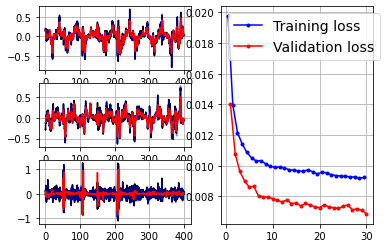

In [2]:

# %% import data
import pandas as pd
import numpy as np
import os


def import_data(logpath="",small_test_dataset=True):

    raw_data=pd.read_csv(log_path)
    
    print("PROCESSING DATA...")
    
    prep_data=raw_data.drop(columns=[i for i in raw_data.keys() if (("forces" in i ) or ('pos' in i) or ("joy" in i)) ])
    prep_data=prep_data.drop(columns=[i for i in raw_data.keys() if (("level" in i ) or ('Unnamed' in i) or ("index" in i)) ])
    
    for i in range(3):
        prep_data['speed_pred[%i]'%(i)]=np.r_[prep_data['speed[%i]'%(i)].values[1:len(prep_data)],0]
        
        
    prep_data['dt']=np.r_[prep_data['t'].values[1:]-prep_data['t'].values[:-1],0]
    prep_data['t']-=prep_data['t'][0]
    prep_data=prep_data.drop(index=[0,len(prep_data)-1])
    prep_data=prep_data.reset_index()
    
    data_prepared=prep_data[:len(prep_data)//50] if small_test_dataset else prep_data
    for k in data_prepared.keys():
        if "speed" in k:
            data_prepared[k]/=25.0
        if 'acc' in k:
            data_prepared[k]/=20.0
        if 'PWM'in k: 
            data_prepared[k]=(data_prepared[k]-1500)/1000    
    
    return data_prepared

def plot_learning_curves(ax,hist):
    loss,val_loss=history.history["loss"], history.history["val_loss"]
    ax.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    ax.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    ax.legend(fontsize=14)
    ax.grid(True)
    
# %% SIMPLE feedforward model: ACC
    # %%% preprocess data

log_path=os.path.join('./logs/avion/vol123/log_real_processed.csv')     
data_prepared=import_data(log_path,small_test_dataset=False)


X_train_full=data_prepared[['speed[0]',
       'speed[1]', 'speed[2]', 'q[0]', 'q[1]', 'q[2]', 'q[3]', 'PWM_motor[1]',
       'PWM_motor[2]', 'PWM_motor[3]', 'PWM_motor[4]', 'PWM_motor[5]',
       'PWM_motor[6]']]

Y_train_full=data_prepared[['acc[0]','acc[1]','acc[2]']]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_train_full, Y_train_full, test_size=0.33, random_state=42)

    # %%% feedforward model
import tensorflow as tf
from tensorflow import keras 

dyn_model=tf.keras.Sequential([keras.layers.Dense(13,activation="relu"),
    keras.layers.Dropout(rate=0.05),
    keras.layers.Dense(13,activation="relu"),
    keras.layers.Dropout(rate=0.05),
    keras.layers.Dense(13),
    keras.layers.Dropout(rate=0.05),
    keras.layers.Dense(7),
    keras.layers.Dropout(rate=0.05),
    keras.layers.Dense(3,activation="tanh")])


dyn_model.compile(loss="mean_squared_error",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  metrics=[tf.keras.metrics.MeanSquaredError()])



history = dyn_model.fit(X_train, y_train, epochs=30,validation_data=(X_test,y_test)) 

    # %%% pred and plot
    
import shutil 
try:
    shutil.rmtree("./MLmodel/acc_plane")
except:
    pass
os.makedirs("./MLmodel/acc_plane")
tf.saved_model.save(dyn_model,"./MLmodel/acc_plane")
acc_pred=dyn_model.predict(X_train_full)                        



import matplotlib.pyplot as plt

plt.figure()
for i in range(3):
    
    ax=plt.gcf().add_subplot(3,2,2*i+1)
    ax.plot(data_prepared['t'],data_prepared['acc[%i]'%(i)],color="black",label="data")
    ax.plot(data_prepared['t'],data_prepared['acc_ned_grad[%i]'%(i)],color="blue",label="data",alpha=0.5)

    ax.plot(data_prepared['t'][np.arange(len(acc_pred))],acc_pred[:,i],color="red",label="pred")
    plt.grid()
    
ax=plt.gcf().add_subplot(1,2,2)
plot_learning_curves(ax,history)

PROCESSING DATA...
Epoch 1/30
1710/1710 [==============================] - 4s 2ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 9.7460e-04 - val_mean_squared_error: 9.7460e-04
Epoch 2/30
1710/1710 [==============================] - 3s 2ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 7.4340e-04 - val_mean_squared_error: 7.4340e-04
Epoch 3/30
1710/1710 [==============================] - 3s 2ms/step - loss: 9.6493e-04 - mean_squared_error: 9.6493e-04 - val_loss: 7.0843e-04 - val_mean_squared_error: 7.0843e-04
Epoch 4/30
1710/1710 [==============================] - 3s 2ms/step - loss: 9.3001e-04 - mean_squared_error: 9.3001e-04 - val_loss: 6.6102e-04 - val_mean_squared_error: 6.6102e-04
Epoch 5/30
1710/1710 [==============================] - 3s 2ms/step - loss: 8.9223e-04 - mean_squared_error: 8.9223e-04 - val_loss: 6.4728e-04 - val_mean_squared_error: 6.4728e-04
Epoch 6/30
1710/1710 [==============================] - 3s 2ms/step - loss: 8.9298e-04 - mean_squ

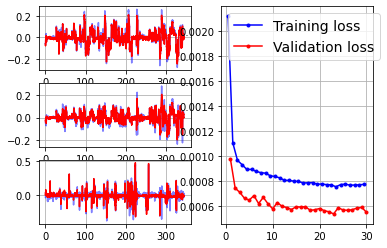

In [5]:

# %% import data
import pandas as pd
import numpy as np
import os


def import_data(logpath="",small_test_dataset=True):

    raw_data=pd.read_csv(log_path)
    
    print("PROCESSING DATA...")
    
    prep_data=raw_data.drop(columns=[i for i in raw_data.keys() if (("forces" in i ) or ('pos' in i) or ("joy" in i)) ])
    prep_data=prep_data.drop(columns=[i for i in raw_data.keys() if (("level" in i ) or ('Unnamed' in i) or ("index" in i)) ])
    
    for i in range(3):
        prep_data['speed_pred[%i]'%(i)]=np.r_[prep_data['speed[%i]'%(i)].values[1:len(prep_data)],0]
        
        
    prep_data['dt']=np.r_[prep_data['t'].values[1:]-prep_data['t'].values[:-1],0]
    prep_data['t']-=prep_data['t'][0]
    prep_data=prep_data.drop(index=[0,len(prep_data)-1])
    prep_data=prep_data.reset_index()
    
    data_prepared=prep_data[:len(prep_data)//50] if small_test_dataset else prep_data
    for k in data_prepared.keys():
        if "speed" in k:
            data_prepared[k]/=25.0
        if 'acc' in k:
            data_prepared[k]/=20.0
        if 'PWM'in k: 
            data_prepared[k]=(data_prepared[k]-1500)/1000    
    
    return data_prepared

def plot_learning_curves(ax,hist):
    loss,val_loss=history.history["loss"], history.history["val_loss"]
    ax.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    ax.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    ax.legend(fontsize=14)
    ax.grid(True)
    
# %% SIMPLE feedforward model: ACC
    # %%% preprocess data

log_path=os.path.join('./logs/copter/vol12/log_real_processed.csv')     
data_prepared=import_data(log_path,small_test_dataset=False)


X_train_full=data_prepared[['speed[0]',
       'speed[1]', 'speed[2]', 'q[0]', 'q[1]', 'q[2]', 'q[3]', 'PWM_motor[1]',
       'PWM_motor[2]', 'PWM_motor[3]', 'PWM_motor[4]', 'PWM_motor[5]',
       'PWM_motor[6]']]

Y_train_full=data_prepared[['acc_ned_grad[0]','acc_ned_grad[1]','acc_ned_grad[2]']]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_train_full, Y_train_full, test_size=0.33, random_state=42)

    # %%% feedforward model
import tensorflow as tf
from tensorflow import keras 

dyn_model=tf.keras.Sequential([keras.layers.Dense(13,activation="relu"),
    keras.layers.Dropout(rate=0.05),
    keras.layers.Dense(13,activation="relu"),
    keras.layers.Dropout(rate=0.05),
    keras.layers.Dense(13),
    keras.layers.Dropout(rate=0.05),
    keras.layers.Dense(7),
    keras.layers.Dropout(rate=0.05),
    keras.layers.Dense(3,activation="tanh")])


dyn_model.compile(loss="mean_squared_error",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  metrics=[tf.keras.metrics.MeanSquaredError()])



history = dyn_model.fit(X_train, y_train, epochs=30,validation_data=(X_test,y_test)) 

    # %%% pred and plot
    
import shutil 

try:
    shutil.rmtree("./MLmodel/acc_copter")
except:
    pass

os.makedirs("./MLmodel/acc_copter")
tf.saved_model.save(dyn_model,"./MLmodel/acc_copter")
acc_pred=dyn_model.predict(X_train_full)                        



import matplotlib.pyplot as plt

plt.figure()
for i in range(3):
    
    ax=plt.gcf().add_subplot(3,2,2*i+1)
#     ax.plot(data_prepared['t'],data_prepared['acc[%i]'%(i)],color="black",label="data")
    ax.plot(data_prepared['t'],data_prepared['acc_ned_grad[%i]'%(i)],color="blue",label="data",alpha=0.5)

    ax.plot(data_prepared['t'][np.arange(len(acc_pred))],acc_pred[:,i],color="red",label="pred")
    plt.grid()
    
ax=plt.gcf().add_subplot(1,2,2)
plot_learning_curves(ax,history)

then we fit the analytical model for planes

In [2]:


import numpy as np
import transforms3d as tf3d
import scipy
from scipy import optimize
# mass=369 #batterie
# mass+=1640-114 #corps-carton
# mass/=1e3
# Area=np.pi*(11.0e-02)**2
# r0=11e-02
# rho0=1.204
# kv_motor=800.0
# pwmmin=1075.0
# pwmmax=1950.0
# U_batt=16.8

# b10=14.44

# %%   ####### IMPORT DATA 

import pandas as pd


log_path="./logs/avion/vol123/log_real_processed.csv"


    
raw_data=pd.read_csv(log_path)



prep_data=raw_data.drop(columns=[i for i in raw_data.keys() if (("forces" in i ) or ('pos' in i) or ("joy" in i)) ])
prep_data=prep_data.drop(columns=[i for i in raw_data.keys() if (("level" in i ) or ('Unnamed' in i) or ("index" in i)) ])



prep_data=prep_data.reset_index()


for i in range(3):
    prep_data['speed_pred[%i]'%(i)]=np.r_[prep_data['speed[%i]'%(i)].values[1:len(prep_data)],0]
    
    
prep_data['dt']=np.r_[prep_data['t'].values[1:]-prep_data['t'].values[:-1],0]
prep_data['t']-=prep_data['t'][0]
prep_data=prep_data.drop(index=[0,len(prep_data)-1])
prep_data=prep_data.reset_index()

data_prepared=prep_data[:len(prep_data)]



def scale_to_01(df):

    return (df-df.min())/(df.max()-df.min())

data_prepared.insert(data_prepared.shape[1],'omega_c[5]',(data_prepared['PWM_motor[5]']-1000)*925.0/1000)
"splitting the dataset into nsecs sec minibatches"

# %% Physical params

   



Aire_1,Aire_2,Aire_3,Aire_4,Aire_0 =    0.62*0.262* 1.292 * 0.5,\
                                    0.62*0.262* 1.292 * 0.5, \
                                    0.34*0.1* 1.292 * 0.5,\
                                    0.34*0.1* 1.292 * 0.5, \
                                    1.08*0.31* 1.292 * 0.5
                                    
Aire_list = [Aire_0,Aire_1,Aire_2,Aire_3,Aire_4]

cp_1,cp_2,cp_3,cp_4,cp_0 = np.array([-0.013,0.475,-0.040],       dtype=float).flatten(), \
                        np.array([-0.013,-0.475,-0.040],      dtype=float).flatten(), \
                        np.array([-1.006,0.17,-0.134],    dtype=float).flatten(),\
                        np.array([-1.006,-0.17,-0.134],   dtype=float).flatten(),\
                        np.array([0.021,0,-0.064],          dtype=float).flatten()
cp_list=[cp_0,cp_1,cp_2,cp_3,cp_4]

#0 : aile centrale
#1 : aile droite
#2 : aile gauche
#3 : vtail droit 
#4 : vtail gauche

theta=45.0/180.0/np.pi

Rvd=np.array([[1.0,0.0,0.0],
              [0.0,np.cos(theta),np.sin(theta)],
              [0.0,-np.sin(theta),np.cos(theta)]])

Rvg=np.array([[1.0,0.0,0.0],
              [0.0,np.cos(theta),-np.sin(theta)],
              [0.0,np.sin(theta),np.cos(theta)]])


forwards=[np.array([1.0,0,0])]*3
forwards.append(Rvd@np.array([1.0,0,0]))
forwards.append(Rvg@np.array([1.0,0,0]))

upwards=[np.array([0.0,0,1.0])]*3
upwards.append(Rvd@np.array([0.0,0,-1.0]))
upwards.append(Rvg@np.array([0.0,0,-1.0]))



crosswards=[np.cross(i,j) for i,j in zip(forwards,upwards)]

# Area=np.pi*(11.0e-02)**2
# r0=11e-02
# rho0=1.204
# kv_motor=800.0
# pwmmin=1075.0
# pwmmax=1950.0
# U_batt=16.8

# vwi0=0.0
# vwj0=0.0
# vwk0=0.0

alpha_0=0.07
alpha_s = 0.3391428111
delta_s = 15.0*np.pi/180
cd0sa_0 = 0.9
cd0fp_0 = 0.010
cd1sa_0 = 2
cl1sa_0 = 5 
cd1fp_0 = 2.5 
coeff_drag_shift_0= 0.5 
coeff_lift_shift_0= 0.05 
coeff_lift_gain_0= 2.5
C_t0 = 1.1e-4
C_q = 1e-8
C_h = 1e-4

# %% Preprocess 


df=data_prepared.copy()


df.insert(data_prepared.shape[1],
          'R',
          [tf3d.quaternions.quat2mat([i,j,k,l]) for i,j,k,l in zip(df['q[0]'],df['q[1]'],df['q[2]'],df['q[3]'])])

R_array=np.array([i for i in df["R"]])

def skew_to_x(S):
    SS=(S-S.T)/2
    return np.array([SS[1,0],SS[2,0],S[2,1]])

def skew(x):
    return np.array([[0,-x[2],x[1]],
                     [x[2],0,-x[0]],
                     [-x[1],x[0],0]])

omegas=np.zeros((R_array.shape[0],3))
omegas[1:]=[skew_to_x(j@(i.T)-np.eye(3)) for i,j in zip(R_array[:-1],R_array[1:])]
omegas[:,0]=omegas[:,0]*1.0/df['dt']
omegas[:,1]=omegas[:,1]*1.0/df['dt']
omegas[:,2]=omegas[:,2]*1.0/df['dt']

def filtering(X,k=0.05):
    Xnew=[X[0]]
    for i,x in enumerate(X[1:]):
        xold=Xnew[-1]
        xnew=xold+k*(x-xold)
        Xnew.append(xnew)
    return np.array(Xnew)

omegas_new=filtering(omegas)

v_ned_array=np.array([df['speed[%i]'%(i)] for i in range(3)]).T

v_body_array=np.array([(i.T@(j.T)).T for i,j in zip(R_array,v_ned_array)])

gamma_array=np.array([(i.T@(np.array([0,0,9.81]).T)).T for i in R_array])

for i in range(3):
    df.insert(df.shape[1],
              'speed_body[%i]'%(i),
              v_body_array[:,i])
    df.insert(df.shape[1],
              'gamma[%i]'%(i),
              gamma_array[:,i])
    df.insert(df.shape[1],
              'omega[%i]'%(i),
              omegas_new[:,i])
    
dragdirs=np.zeros((v_body_array.shape[0],3,5))
liftdirs=np.zeros((v_body_array.shape[0],3,5))
slipdirs=np.zeros((v_body_array.shape[0],3,5))

alphas=np.zeros((v_body_array.shape[0],1,5))
sideslips=np.zeros((v_body_array.shape[0],1,5))

for k,v_body in enumerate(v_body_array):
    
    
    v_in_ldp=np.cross(crosswards,np.cross((v_body-np.cross(cp_list,omegas_new[k])),crosswards))
    
    dd=-v_in_ldp
    dd=dd.T@np.diag(1.0/(np.linalg.norm(dd,axis=1)+1e-8))

    ld=np.cross(crosswards,v_in_ldp)
    ld=ld.T@np.diag(1.0/(np.linalg.norm(ld,axis=1)+1e-8))
              
    sd=-(v_body-np.cross(cp_list,omegas_new[k])-v_in_ldp)
    sd=sd.T@np.diag(1.0/(np.linalg.norm(sd,axis=1)+1e-8))
    
    dragdirs[k,:,:]=R_array[k]@(dd@np.diag(Aire_list)*np.linalg.norm(v_in_ldp)**2)
    liftdirs[k,:,:]=R_array[k]@(ld@np.diag(Aire_list)*np.linalg.norm(v_in_ldp)**2)
    slipdirs[k,:,:]=R_array[k]@(sd@np.diag(Aire_list)*np.linalg.norm(v_in_ldp)**2)
    
    alphas_d=np.diag(v_in_ldp@(np.array(forwards).T))/(np.linalg.norm(v_in_ldp,axis=1)+1e-8)
    alphas_d=np.arccos(alphas_d)
    alphas_d=np.sign(np.diag(v_in_ldp@np.array(upwards).T))*alphas_d
    
    x=np.linalg.norm(v_in_ldp,axis=1)
    y=np.linalg.norm(v_body-np.cross(cp_list,omegas_new[k])-v_in_ldp,axis=1)
    sideslips_d=np.arctan2(y,x)
        
    alphas[k,:,:]=alphas_d
    sideslips[k,:,:]=sideslips_d

    
df.insert(df.shape[1],
          'liftdirs',
          [i for i in liftdirs])
        
df.insert(df.shape[1],
          'dragdirs',
          [i for i in dragdirs])     

df.insert(df.shape[1],
          'slipdirs',
          [i for i in slipdirs])  
        
df.insert(df.shape[1],
          'alphas',
          [i for i in alphas])    

df.insert(df.shape[1],
          'sideslips',
          [i for i in sideslips])    

df.insert(df.shape[1],
          'thrust_dir_ned',
          [i[:,0]*j**2 for i,j in zip(df['R'],df['omega_c[5]'])])

import numpy as np
delt=np.array([df['PWM_motor[%i]'%(i)] for i in range(1,5)]).T
delt=np.concatenate((np.zeros((len(df),1)),delt),axis=1).reshape(-1,1,5)
delt=(delt-1530)/500*15.0/180.0*np.pi
delt[:,:,0]*=0
delt[:,:,2]*=-1.0
delt[:,:,4]*=-1.0

df.insert(df.shape[1],
          'deltas',
          [i for i in delt])

# %% plot
# import matplotlib.pyplot as plt
# plt.figure()
# plt.plot(v_ned_array.reshape(-1,3),label="ned"),plt.grid(),plt.legend()


# plt.figure()
# plt.plot(v_body_array.reshape(-1,3),label="body"),plt.grid(),plt.legend()

# plt.figure()
# plt.plot(alphas.reshape(-1,5),label="alpha"),plt.grid(),plt.legend()

# plt.figure()
# plt.plot(delt.reshape(-1,5),label="deltas"),plt.grid(),plt.legend()
# plt.figure()
# for i in range(3):
#     plt.plot(dragdirs[:,:,i].reshape(-1,3),label="dragdirs")
# plt.grid(),plt.legend()
# plt.figure()
# for i in range(3):
#     plt.plot(liftdirs[:,:,i].reshape(-1,3),label="liftdirs")
# plt.grid(),plt.legend()

# %% usefuncs

alpha_0=0.07
alpha_s = 0.3391428111
delta_s = 15.0*np.pi/180
cd0sa_0 = 0.9
cd0fp_0 = 0.010
cd1sa_0 = 2
cl1sa_0 = 5 
cd1fp_0 = 2.5 
coeff_drag_shift_0= 0.5 
coeff_lift_shift_0= 0.05 
coeff_lift_gain_0= 2.5
C_t0 = 1.1e-4
C_q = 1e-8
C_h = 1e-4

ct = 1.1e-4
a_0 =  0.07
a_s =  0.3391
d_s =  15.0*np.pi/180
cl1sa = 5
cd1fp = 2.5
k0 = 0.1
k1 = 0.1
k2 = 0.1
cd0fp =  1e-2
cd0sa = 0.3
cd1sa = 1.0
m= 8.5

coeffs_0=np.array([ct,
                   a_0,
                   a_s,
                   d_s, 
                   cl1sa, 
                   cd1fp, 
                   k0, k1, k2, 
                   cd0fp, 
                   cd0sa, cd1sa,m])

# %% OPTI SIMPLE
# %%% usefuncs
def dyn(df=df,coeffs=coeffs_0,fix_mass=False,fix_ct=False):
    
    ct,a_0, a_s, d_s, cl1sa, cd1fp, k0, k1, k2, cd0fp, cd0sa, cd1sa,m=coeffs
    
    ct= 2.0*1.1e-4 if fix_ct else ct
    m= 8.5 if fix_mass else m
    
    "compute aero coeffs "
    
    a=np.array([i for i in df['alphas']])
    d_0=np.array([i for i in df['deltas']])
    a_0_arr=a_0*np.ones(d_0.shape)
    a_0_arr[:,-2:]*=0
    
    CL_sa = 1/2 * cl1sa * np.sin(2*(a + (k1*d_0) + a_0))
    CD_sa = cd0sa + cd1sa * np.sin((a + (k0*d_0) + a_0))**2

    CL_fp = 1/2 * cd1fp * np.sin((2*(a+ (k1*d_0) + a_0)))
    CD_fp = cd0fp + cd1fp * np.sin((a + (k0*d_0) + a_0))**2

    puiss=5
    s = 1.0 - ((a+a_0)**2/a_s**2)**puiss/(((a+a_0)**2/a_s**2)**puiss + 100+200*d_s)

    C_L = CL_fp + s*(CL_sa - CL_fp) + k2 * np.sin(d_0)
    C_D = CD_fp + s*(CD_sa - CD_fp)
    
    #C_L,C_D shape is (n_samples,1,n_surfaces)
    
    # lifts,drags
    ld,dd=np.array([i for i in df['liftdirs']]),np.array([i for i in df['dragdirs']])
    
    lifts=C_L*ld    
    drags=C_D*dd
    
    aeroforce_total=np.sum(lifts+drags,axis=2)
    
    # "compute thrust  "

    T=ct*np.array([i for i in df['thrust_dir_ned']])
    g=np.zeros(aeroforce_total.shape)
    g[:,-1]+=9.81
    forces_total=T+aeroforce_total+m*g
    acc=forces_total/m
    
    return acc


acc_log=np.array([df['acc[%i]'%(i)] for i in range(3)]).T


def cost(X,fm=False,fct=False):
    
    X0=X*coeffs_0
    acc=dyn(df,X0,fix_mass=fm,fix_ct=fct)
    c=np.mean(np.linalg.norm((acc-acc_log),axis=1))
    # list_to_print=[i for i in X]+c
    # print(str(list_to_print))
    str_top_print="\r "
    for i in X:
        str_top_print=str_top_print+str(round(i,ndigits=5))+" |"
    str_top_print=str_top_print+" "+str(round(c,ndigits=5))
    
#     res={}
#     l="ct,a_0, a_s, d_s, cl1sa, cd1fp, k0, k1, k2, cd0fp, cd0sa, cd1sa,m"
#     for i,j in zip(l.split(","),X0):
#         res[i]=round(j,ndigits=5)       
#     res['cost']=c
#     print(res)
    return c

    


# %%% BOUNDS


bounds_ct= (0.2e-4,6e-4) #1.1e-4/4 1.1e-4*4
bounds_a_0= (-0.26,0.26) #15 deg
bounds_a_s= (-0.52,0.52)  #2 alophao 0
bounds_d_s= (0,0.75) #2 45 degres
bounds_cl1sa =(None,None)
bounds_cd1fp =(None,None)
bounds_k0 =(None,None)
bounds_k1 =(None,None)
bounds_k2 =(None,None)
bounds_cd0fp =(None,None)
bounds_cd0sa =(None,None)
bounds_cd1sa= (None,None)
bounds_mass=(5,15)


bounds=[bounds_a_0,
        bounds_a_s,
        bounds_d_s,
        bounds_cl1sa,
        bounds_cd1fp,
        bounds_k0,
        bounds_k1,
        bounds_k2,
        bounds_cd0fp,
        bounds_cd0sa,
        bounds_cd1sa        ]

bounds.insert(0, bounds_ct)
bounds.append( bounds_mass)

import matplotlib.pyplot as plt

def pwcolor(sol,col="red",tit=None,fm=False,fct=False):

    

    Xsol=sol['x']

    
    X0=Xsol*coeffs_0
    acc_sol=dyn(df,X0,fix_mass=fm,fix_ct=fct)
    
    print("SOL : ",X0)
    print("PARAMS : ",col,tit)
    
    plt.figure()
    if tit is not None and type(tit) is str:
        plt.title(tit)
    for i in range(1,4):
        plt.gcf().add_subplot(3,1,i)
        plt.plot(acc_log[:,i-1],label="log",color="black")
        plt.plot(acc_sol[:,i-1],label="pred",color=col)
        plt.legend(),plt.grid()
    plt.draw_all(force=True)
    return


# %%% Minimize
scipy_init_x=np.ones(len(coeffs_0))




# sol=scipy.optimize.minimize(cost,scipy_init_x,args=("True","False"))
# pwcolor(sol,"purple","fm",True,False)

# sol=scipy.optimize.minimize(cost,scipy_init_x,args=("False","True"))
# pwcolor(sol,"green","fct",False,True)

# sol=scipy.optimize.minimize(cost,scipy_init_x,args=("True","True"))
# pwcolor(sol,"grey","both fixed",True,True)

# sol=scipy.optimize.minimize(cost,scipy_init_x,method="SLSQP")
# pwcolor(sol,"red","slsqp")

# sol=scipy.optimize.minimize(cost,scipy_init_x,)
# pwcolor(sol,"blue"," ")



import json


    
def run_parallel(x):
        meth,fm,fc=x
        sol=scipy.optimize.minimize(cost,scipy_init_x,
        args=(fm,fc),method=meth,options={"maxiter":400})
        filename="SIMPLE_meth_"+str(meth)+"_fm_"+str(fm)+"_fc_"+str(fc)
        with open('./scipy_solve/%s.json'%(filename), 'w') as fp:
            json_dump={"cost":sol['fun'],"X":sol['x'].tolist()}
            json.dump(json_dump, fp)

        return
    
from multiprocessing import Pool

if __name__ == '__main__':

    

    meth_range=["SLSQP","L-BFGS-B"]   
    fm_range=[True,False]
    fc_range=[True,False]

    
    x_r=[[i,j,k] for i in meth_range for j in  fm_range  for k in fc_range]

  
    pool = Pool(processes=len(x_r))
    # alidhali=input('LAUNCH ? ... \n >>>>')
    pool.map(run_parallel, x_r)


# run(int(input('LAUNCH ? ... \n >>>>')))





print('DONE!')

In [1]:




# %% OPTI MULTICOEFFS

alpha_0=0.07
alpha_s = 0.3391428111
delta_s = 15.0*np.pi/180
cd0sa_0 = 0.9
cd0fp_0 = 0.010
cd1sa_0 = 2
cl1sa_0 = 5 
cd1fp_0 = 2.5 
coeff_drag_shift_0= 0.5 
coeff_lift_shift_0= 0.05 
coeff_lift_gain_0= 2.5
C_t0 = 1.1e-4
C_q = 1e-8
C_h = 1e-4

ct = 1.1e-4
a_0 =  0.07
a_s =  0.3391
d_s =  15.0*np.pi/180
cl1sa = 5
cd1fp = 2.5
k0 = 0.1
k1 = 0.1
k2 = 0.1
cd0fp =  1e-2
cs= 0.5
cl1fp=5
cd0sa = 0.3
cd1sa = 1.0
m= 8.5

coeffs_0_complex=np.array([ct,
                   a_0,
                   a_s,
                   d_s, 
                   cl1sa, 
                   cl1fp,
                   k0, k1, k2, 
                   cs,
                   cd0fp, cd0sa, 
                   cd1sa, cd1fp,
                   a_0,
                   a_s,
                   d_s, 
                   cl1sa, 
                   cl1fp,
                   k0, k1, k2,
                   cs,
                   cd0fp, cd0sa, 
                   cd1sa, cd1fp,
                   m])


coeffs_0_complex=np.ones(len(coeffs_0_complex))

# %%% funcs

def pwcolor_complex(sol,col="red",tit=None,fm=False,fct=False,noslip=False):

    

    Xsol=sol['x']
    
    X0=Xsol*coeffs_0_complex
    acc_sol=dyn_complex(df,X0,fix_mass=fm,fix_ct=fct,no_slip=noslip)
    
    print("SOL : ",X0)
    print("PARAMS : ",col,tit)
    
    plt.figure()
    if tit is not None and type(tit) is str:
        plt.title(tit)
    for i in range(1,4):
        plt.gcf().add_subplot(3,1,i)
        plt.plot(acc_log[:,i-1],label="log",color="black")
        plt.plot(acc_sol[:,i-1],label="pred",color=col)
        plt.legend(),plt.grid()
    plt.draw_all(force=True)
    return

def dyn_complex(df=df,coeffs=coeffs_0_complex,fix_mass=False,fix_ct=False,no_slip=False):
    
    ct,\
    a_0, a_s, d_s, cl1sa, cl1fp, k0, k1, k2, cs, cd0fp, cd0sa, cd1sa, cd1fp, \
    a_0_v, a_s_v, d_s_v, cl1sa_v, cl1fp_v, k0_v, k1_v, k2_v, cs_v, cd0fp_v, cd0sa_v, cd1sa_v, cd1fp_v, \
    m=coeffs
    
    ct= 2.0*1.1e-4 if fix_ct else ct
    m= 8.5 if fix_mass else m
    
    "compute aero coeffs "
    
    a=np.array([i for i in df['alphas']])
    sideslip=np.array([i for i in df['sideslips']])
    d_0=np.array([i for i in df['deltas']])
    
    a_0_arr=np.ones(d_0.shape)@np.diag([a_0,a_0,a_0,a_0_v,a_0_v])

    k0d0=d_0@np.diag([k0,k0,k0,k0_v,k0_v])
    k1d0=d_0@np.diag([k1,k1,k1,k1_v,k1_v])

    
    
    CL_sa = 1/2  * np.sin(2*(a + (k1d0) + a_0_arr)) @ np.diag([cl1sa,
                                                           cl1sa,
                                                           cl1sa,
                                                           cl1sa_v,
                                                           cl1sa_v])
    
    CD_sa = np.ones(a.shape)@ np.diag([cd0sa,
                                        cd0sa,
                                        cd0sa,
                                        cd0sa_v,
                                        cd0sa_v])
    
    CD_sa = CD_sa + np.sin((a + (k0d0) + a_0_arr))**2 @ np.diag([cd1sa,
                                                           cd1sa,
                                                           cd1sa,
                                                           cd1sa_v,
                                                           cd1sa_v])
    
    
    

    CL_fp = 1/2  * np.sin(2*(a + (k1d0) + a_0_arr)) @ np.diag([cl1fp,
                                                           cl1fp,
                                                           cl1fp,
                                                           cl1fp_v,
                                                           cl1fp_v])
    
    CD_fp = np.ones(a.shape)@ np.diag([cd0fp,
                                        cd0fp,
                                        cd0fp,
                                        cd0fp_v,
                                        cd0fp_v])
    
    CD_fp = CD_fp + np.sin((a + (k0d0) + a_0_arr))**2 @ np.diag([cd1fp,
                                                           cd1fp,
                                                           cd1fp,
                                                           cd1fp_v,
                                                           cd1fp_v])
    
    

    puiss=5
    s = - ((a+a_0)**2 @(np.diag(1.0/np.array([a_s,
                                              a_s,
                                              a_s,
                                              a_s_v,
                                              a_s_v])))**2)**puiss
    s = s @ (((a+a_0)**2@(np.diag(1.0/np.array([a_s,
                                                a_s,
                                                a_s,
                                                a_s_v,
                                                a_s_v])))**2)**puiss+ 100+200* np.diag([ d_s,
                                                                                        d_s,
                                                                                        d_s
                                                                                        ,d_s_v,
                                                                                        d_s_v]))
    s = s+1


    C_L = CL_fp + s*(CL_sa - CL_fp) 
    C_L = C_L + np.sin(d_0)@np.diag([k2,k2,k2,k2_v,k2_v])
    C_D = CD_fp + s*(CD_sa - CD_fp)
    C_S =np.sin(sideslip)@np.diag([cs,cs,cs,cs_v,cs_v])
    #C_L,C_D shape is (n_samples,1,n_surfaces)
    
    # lifts,drags
    ld,dd=np.array([i for i in df['liftdirs']]),np.array([i for i in df['dragdirs']])
    sd=np.array([i for i in df['sideslips']])
    
    lifts=C_L*ld    
    drags=C_D*dd
    sweep=C_S*sd
    # aeroforce_total=np.sum(lifts+drags,axis=2)
    aeroforce_total=np.sum(lifts+drags,axis=2)  if no_slip else  np.sum(lifts+drags+sweep,axis=2) 
    # "compute thrust  "

    T=ct*np.array([i for i in df['thrust_dir_ned']])
    g=np.zeros(aeroforce_total.shape)
    g[:,-1]+=9.81
    forces_total=T+aeroforce_total+m*g
    acc=forces_total/m
    
    return acc


acc_log=np.array([df['acc[%i]'%(i)] for i in range(3)]).T

def cost_ext(X,fm=False,fct=False,no_slip=False,verbose=True):
    
    X0=X*coeffs_0_complex
    acc=dyn_complex(df,X0,fix_mass=fm,fix_ct=fct,no_slip=no_slip)
    c=np.mean(np.linalg.norm((acc-acc_log),axis=1))

#     res={}
#     res['cost']=c
#     print(res) if verbose else None
    return c

scipy_init_x_complex=np.ones(len(coeffs_0_complex))

# %%% Minimize

def run(num=-1):
    
    print("RUNNING .... ALGO  %i \n"%(num))
    
    if num==1:
        sol=scipy.optimize.minimize(cost_ext,scipy_init_x_complex,
        args=(True,True),method="SLSQP",options={"maxiter":400})
        pwcolor_complex(sol,"purple","slsqp both fixed",fm=True,fct=True)

    if num==2:
        sol=scipy.optimize.minimize(cost_ext,scipy_init_x_complex,
        args=(True,False),method="SLSQP",options={"maxiter":400})
        pwcolor_complex(sol,"green","fm slsqp",fm=True,fct=False)

    if num==3:
        sol=scipy.optimize.minimize(cost_ext,scipy_init_x_complex,
        args=(False,True),method="SLSQP",options={"maxiter":400})
        pwcolor_complex(sol,"grey","fct slsqp",fm=False,fct=True)
        
    if num==4:
        sol=scipy.optimize.minimize(cost_ext,scipy_init_x_complex,
        method="SLSQP",options={"maxiter":400})
        pwcolor_complex(sol,"orange","slsqp",fm=False,fct=False)
        
    if num==5:
        sol=scipy.optimize.minimize(cost_ext,scipy_init_x_complex,
        args=(True,True),method="L-BFGS-B",options={"maxiter":400})
        pwcolor_complex(sol,"cyan","bfgs both fixed",fm=True,fct=True)

    if num==6:
        sol=scipy.optimize.minimize(cost_ext,scipy_init_x_complex,
        args=(True,False),method="L-BFGS-B",options={"maxiter":400})
        pwcolor_complex(sol,"brown","fm bfgs",fm=True,fct=False)

    if num==7:
        sol=scipy.optimize.minimize(cost_ext,scipy_init_x_complex,
        args=(False,True),method="L-BFGS-B",options={"maxiter":400})
        pwcolor_complex(sol,"pink","fct bfgs",fm=False,fct=True)

    if num==8:
        sol=scipy.optimize.minimize(cost_ext,scipy_init_x_complex,
        method="L-BFGS-B",options={"maxiter":400})
        pwcolor_complex(sol,"red","bfgs",fm=False,fct=False)

    if num==9:
        sol=scipy.optimize.minimize(cost_ext,scipy_init_x_complex,
        args=(True,True),method="SLSQP",options={"maxiter":400})
        pwcolor_complex(sol,"purple","slsqp both fixed",fm=True,fct=True)

    if num==10:
        sol=scipy.optimize.minimize(cost_ext,scipy_init_x_complex,
        args=(True,False),method="SLSQP",options={"maxiter":400})
        pwcolor_complex(sol,"green","fm slsqp",fm=True,fct=False)

    if num==11:
        sol=scipy.optimize.minimize(cost_ext,scipy_init_x_complex,
        args=(False,True),method="SLSQP",options={"maxiter":400})
        pwcolor_complex(sol,"grey","fct slsqp",fm=False,fct=True)
        
    if num==12:
        sol=scipy.optimize.minimize(cost_ext,scipy_init_x_complex,
        method="SLSQP",options={"maxiter":400})
        pwcolor_complex(sol,"orange","slsqp",fm=False,fct=False)
        
    if num==13:
        sol=scipy.optimize.minimize(cost_ext,scipy_init_x_complex,
        args=(True,True),method="L-BFGS-B",options={"maxiter":400})
        pwcolor_complex(sol,"cyan","bfgs both fixed",fm=True,fct=True)

    if num==14:
        sol=scipy.optimize.minimize(cost_ext,scipy_init_x_complex,
        args=(True,False),method="L-BFGS-B",options={"maxiter":400})
        pwcolor_complex(sol,"brown","fm bfgs",fm=True,fct=False)

    if num==15:
        sol=scipy.optimize.minimize(cost_ext,scipy_init_x_complex,
        args=(False,True),method="L-BFGS-B",options={"maxiter":400})
        pwcolor_complex(sol,"pink","fct bfgs",fm=False,fct=True)

    if num==16:
        sol=scipy.optimize.minimize(cost_ext,scipy_init_x_complex,
        method="L-BFGS-B",options={"maxiter":400})
        pwcolor_complex(sol,"red","bfgs",fm=False,fct=False)


    print("\n #################################\nN %i"%(num),"\n",sol)
    return True

import json

def run_parallel(x):
        meth,fm,fc,sideslip=x
        sol=scipy.optimize.minimize(cost_ext,scipy_init_x_complex,
        args=(fm,fc,sideslip),method=meth,options={"maxiter":400})
        filename="COMPLEX_meth_"+str(meth)+"_fm_"+str(fm)+"_fc_"+str(fc)+"_sideslip_"+str(sideslip)
        with open('./scipy_solve/%s.json'%(filename), 'w') as fp:
            json_dump={"cost":sol['fun'],"X":sol['x'].tolist()}
            json.dump(json_dump, fp)
        return

from multiprocessing import Pool

if __name__ == '__main__':

    

    meth_range=["SLSQP","L-BFGS-B"]   
    fm_range=[True,False]
    fc_range=[True,False]
    sidslip_range=[True,False]

    x_r=[[i,j,k,l] for i in meth_range for j in  fm_range  for k in fc_range for l in sidslip_range]

  
    pool = Pool(processes=len(x_r))
    # alidhali=input('LAUNCH ? ... \n >>>>')
    pool.map(run_parallel, x_r)


# run(int(input('LAUNCH ? ... \n >>>>')))







NameError: name 'np' is not defined

Comparing both